In [1]:
from bs4 import BeautifulSoup
import random
# Requests
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
df_categoria = pd.read_csv('../datos/categorias.csv')
df_mergeo_1 = pd.read_csv('../datos/precios_mergeo.csv')
df_supermercado = pd.read_csv('../datos/supermercados.csv')

Conexión a DDBB

In [96]:
try:
    conexion = psycopg2.connect(
    database = 'Supermercados',
    user = 'postgres',
    password = 'admin',
    host = 'localhost',
    port = '5432')
except OperationalError as e: #el alias es e
    if e.pgcode == errorcodes.INVALID_PASSWORD:
        print('la contraseña es erronea')
    elif e.pgcode == errorcodes.CONNECTION_EXCEPTION:
        print('error de conexion')
    else:
        print(f'el error es el siguiente {e}')

Creación de la tabla de supermercados.

In [5]:
cursor = conexion.cursor() #para crear la tabla desde aquí
query_creacion_supermercados = """ 
    CREATE TABLE IF NOT EXISTS Supermercado (
    Id_Supermercado int PRIMARY KEY,
    Supermercado varchar(100));

"""

cursor.execute(query_creacion_supermercados)
conexion.commit()

In [6]:
lista_tuplas2 = []
for fila in df_supermercado.values:
    lista_tuplas2.append(tuple(fila))

In [7]:
lista_tuplas2

[(1, 'mercadona'),
 (2, 'carrefour'),
 (3, 'eroski'),
 (4, 'dia'),
 (5, 'hipercor'),
 (6, 'alcampo')]

In [8]:
query_creacion_supermercados = 'INSERT INTO Supermercado (Id_Supermercado, Supermercado) VALUES (%s, %s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas2:
    cursor.execute(query_creacion_supermercados, valores)
conexion.commit()

UniqueViolation: llave duplicada viola restricción de unicidad «supermercado_pkey»
DETAIL:  Ya existe la llave (id_supermercado)=(1).


Creación de la tabla Categorías

In [76]:
cursor = conexion.cursor() 
query_creacion_categorias = """ 
    CREATE TABLE IF NOT EXISTS Categoria (
    Id_Categoria int PRIMARY KEY,
    Categoria varchar(100));

"""
cursor.execute(query_creacion_categorias)
conexion.commit()


In [77]:
lista_tuplas3 = []
for fila in df_categoria.values:
    lista_tuplas3.append(tuple(fila))

In [78]:
lista_tuplas3

[(1, 'aceite-de-girasol'), (2, 'aceite-de-oliva'), (3, 'leche')]

In [79]:
query_creacion_categorias = 'INSERT INTO Categoria (Id_Categoria, Categoria) VALUES (%s, %s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas3:
    cursor.execute(query_creacion_categorias, valores)
conexion.commit()

In [80]:
cursor = conexion.cursor() 
query_creacion_tabla_historica = """ 
    CREATE TABLE IF NOT EXISTS datos_historicos (
    Fecha DATE,
    Precio FLOAT NOT NULL,
    Variación FLOAT,
    Artículo VARCHAR(300),
    Id_Categoria INT,
    Id_Supermercado INT,
    CONSTRAINT fk_Categoría FOREIGN KEY (Id_Categoria)
        REFERENCES Categoria(Id_Categoria),
    CONSTRAINT fk_Supermercado FOREIGN KEY (Id_Supermercado)
        REFERENCES Supermercado(Id_Supermercado)
);
"""

cursor.execute(query_creacion_tabla_historica)
conexion.commit()


In [81]:
lista_tuplas1 = []
for fila in df_mergeo_1.values:
    lista_tuplas1.append(tuple(fila))

In [82]:
query_creacion_tabla_historica = 'INSERT INTO datos_historicos (Fecha, Precio, Variación, Artículo, Id_Categoria, Id_Supermercado) VALUES (%s, %s, %s, %s, %s,%s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas1:
    cursor.execute(query_creacion_tabla_historica, valores)
conexion.commit()

Queries

Comparar precios entre supermercados: determinar qué supermercados ofrecen los precios más bajos y cuáles son más caros para cada producto.

In [264]:
cursor=conexion.cursor()
query_min_max_cat="""
SELECT min(precio) AS precio_minimo, max(precio) AS precio_maximo, s.supermercado , c.categoria 
FROM datos_historicos dh 
inner JOIN supermercado s 
ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c 
ON dh.id_categoria = c.id_categoria 
WHERE dh.fecha = '26-10-2024'
GROUP BY c.categoria, s.supermercado 
ORDER BY c.categoria, s.supermercado;
"""
cursor.execute(query_min_max_cat)
df_min_max_= pd.DataFrame(cursor.fetchall())

In [265]:
df_min_max_.head()

,0,1,2,3
0,1.45,15.88,alcampo,aceite-de-girasol
1,1.48,37.04,carrefour,aceite-de-girasol
2,1.53,9.98,dia,aceite-de-girasol
3,1.48,11.99,eroski,aceite-de-girasol
4,1.41,8.15,hipercor,aceite-de-girasol


In [266]:
# Renombrar las columnas de acuerdo a su contenido
df_min_max_.columns = ['precio_minimo', 'precio_maximo', 'supermercado', 'categoria']

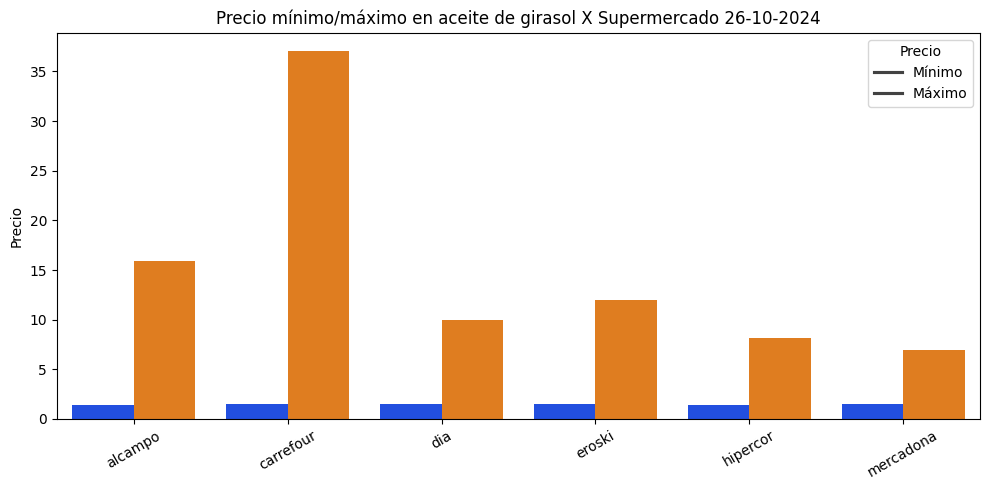

In [280]:
df_long = pd.melt(df_min_max_, id_vars=['categoria', 'supermercado'], 
                  value_vars=['precio_minimo', 'precio_maximo'], 
                  var_name='tipo_precio', value_name='precio')

# Filtrar solo la categoría "aceite-de-girasol" si hay múltiples categorías en el DataFrame
df_aceite = df_long[df_long['categoria'] == 'aceite-de-girasol']

# Crear el gráfico de barras agrupado
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_aceite, 
    x='supermercado', 
    y='precio', 
    hue='tipo_precio', 
    palette="bright"
)

# Personalizar etiquetas y título
plt.title("Precio mínimo/máximo en aceite de girasol X Supermercado 26-10-2024")
plt.xlabel("")
plt.ylabel("Precio")
plt.legend(title="Precio", labels=["Mínimo", "Máximo"])
plt.xticks(rotation=30)  # Asegura que los nombres de supermercados se vean claramente
plt.tight_layout()
plt.show()



Tomando en consideración que fueron recopilados los datos de todos los mercados (6), hasta la fecha 26-10-2024, hice la llamada para ver los precios mínimos y máximos para cada categoría en esta fecha.
* En cuanto a precio mínimo, el rango de precio tiene mucha similitud entre todos por lo que no existe gran variabilidad. Sin embargo, cabe señalar el precio mínimo del aceite de girasol en Hipercor (1.41).
* En cuanto a precio máximo, el rango de precio si tiene algunas diferencias significativas señalando Carrefour como el mercado con el precio mayor. Es preciso decir que a la hora de tomar los datos no se tomó en cuenta la diferenciación entre tipos de artículos dentro de cada categoría por lo que aquí entra las distintas presentaciones de cada artículo. Este precio mayor puede ser el resultado de un producto de una cantidad mayor que en otros mercads, un farjo o grupo de 6 en 1litro.

Debajo se presenta una tabla donde nos muestra tanto los mínimos como los máximos de esta categoría 'aceite de girasol' para cada mercado.

In [285]:
df_aceite.T

,0,1,2,3,4,5,18,19,20,21,22,23
categoria,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol,aceite-de-girasol
supermercado,alcampo,carrefour,dia,eroski,hipercor,mercadona,alcampo,carrefour,dia,eroski,hipercor,mercadona
tipo_precio,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo
precio,1.45,1.48,1.53,1.48,1.41,1.48,15.88,37.04,9.98,11.99,8.15,6.91


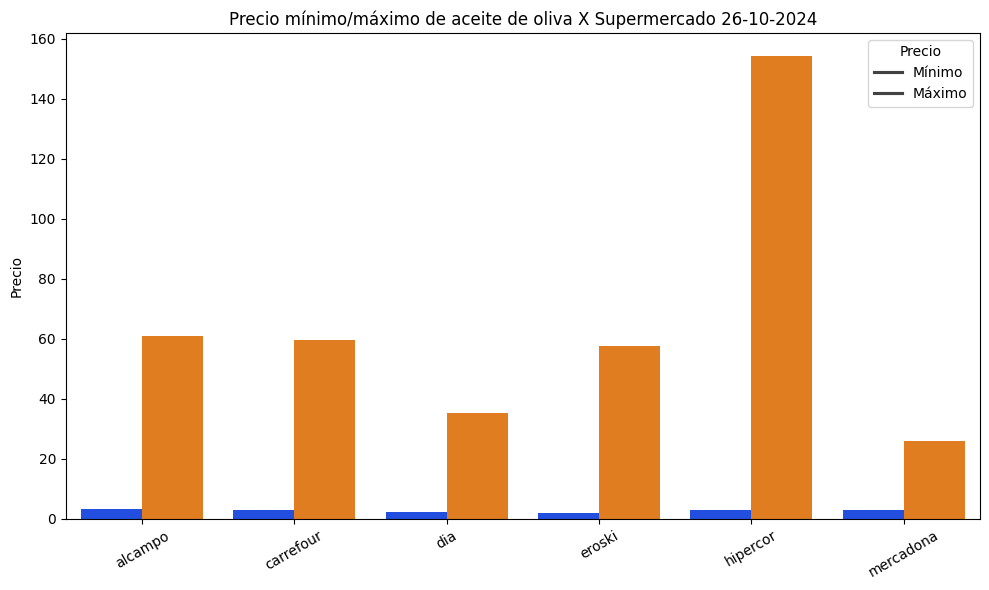

In [284]:
df_aceite_oliva = df_long[df_long['categoria'] == 'aceite-de-oliva']

# Crear el gráfico de barras agrupado
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_aceite_oliva, 
    x='supermercado', 
    y='precio', 
    hue='tipo_precio', 
    palette="bright"
)

plt.title("Precio mínimo/máximo de aceite de oliva X Supermercado 26-10-2024")
plt.xlabel("")
plt.ylabel("Precio")
plt.legend(title="Precio", labels=["Mínimo", "Máximo"])
plt.xticks(rotation=30)  
plt.tight_layout()
plt.show()

Tomando en consideración que fueron recopilados los datos de todos los mercados (6), hasta la fecha 26-10-2024, hice la llamada para ver los precios mínimos y máximos para cada categoría en esta fecha.
* En cuanto a precio mínimo de aceite de oliva, el rango de precio tiene algo mas de disparidad entre todos. Podemos destacar que el precio mínimo del aceite de girasol en Eroski es 1.89.
* En cuanto a precio máximo, el rango de precio si tiene algunas diferencias significativas señalando Hipercor como el mercado con el precio mayor. Es preciso decir que a la hora de tomar los datos no se tomó en cuenta la diferenciación entre tipos de artículos dentro de cada categoría por lo que aquí entra las distintas presentaciones de cada artículo. Este precio mayor puede ser el resultado de un producto de una cantidad mayor que en otros mercados, un farjo o grupo de 6 en 1litro, incluso hasta 15 litros.

Debajo se presenta una tabla donde nos muestra tanto los mínimos como los máximos de esta categoría 'aceite de oliva' para cada mercado.

In [278]:
df_aceite_oliva.T

,6,7,8,9,10,11,24,25,26,27,28,29
categoria,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva,aceite-de-oliva
supermercado,alcampo,carrefour,dia,eroski,hipercor,mercadona,alcampo,carrefour,dia,eroski,hipercor,mercadona
tipo_precio,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo
precio,3.35,2.9,2.15,1.89,2.9,2.9,60.94,59.57,35.14,57.79,154.32,25.95


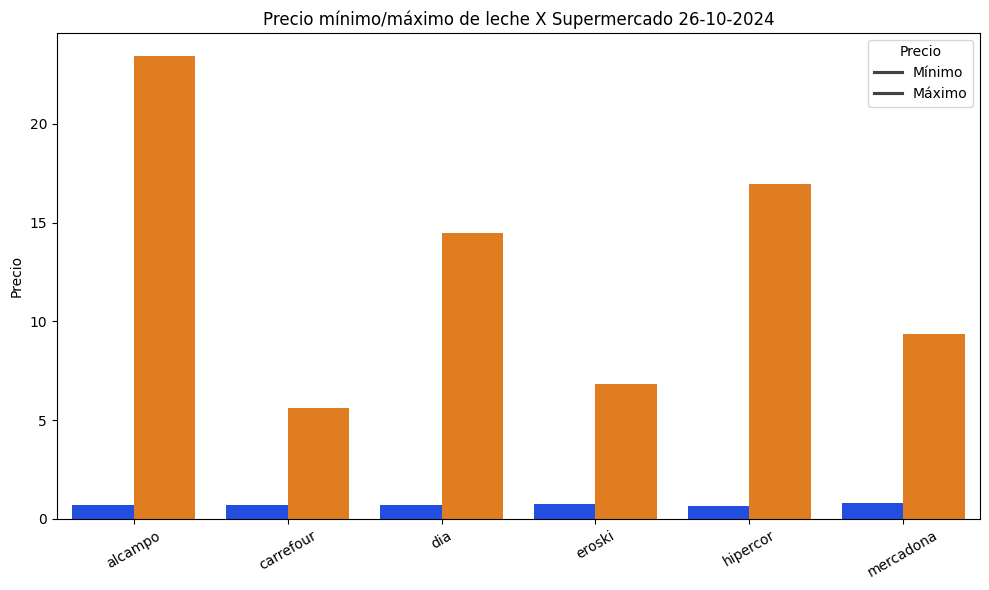

In [281]:
df_leche = df_long[df_long['categoria'] == 'leche']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_leche, 
    x='supermercado', 
    y='precio', 
    hue='tipo_precio', 
    palette="bright"
)

plt.title("Precio mínimo/máximo de leche X Supermercado 26-10-2024")
plt.xlabel("")
plt.ylabel("Precio")
plt.legend(title="Precio", labels=["Mínimo", "Máximo"])
plt.xticks(rotation=30)  
plt.tight_layout()
plt.show()

Tomando en consideración que fueron recopilados los datos de todos los mercados (6), hasta la fecha 26-10-2024, hice la llamada para ver los precios mínimos y máximos para cada categoría en esta fecha.
* En cuanto a precio mínimo de la leche, el rango de precio tiene algo mas de disparidad entre todos. Podemos destacar que el precio mínimo de la leche en Hipercor es 0.67.
* En cuanto a precio máximo, el rango de precio encuentro diferencias señalando Alcampo como el mercado con el precio mayor. Es preciso decir que a la hora de tomar los datos no se tomó en cuenta la diferenciación entre tipos de artículos dentro de cada categoría por lo que aquí entra las distintas presentaciones de cada artículo. 

Debajo se presenta una tabla donde nos muestra tanto los mínimos como los máximos de esta categoría 'leche' para cada mercado.

In [279]:
df_leche.T

,12,13,14,15,16,17,30,31,32,33,34,35
categoria,leche,leche,leche,leche,leche,leche,leche,leche,leche,leche,leche,leche
supermercado,alcampo,carrefour,dia,eroski,hipercor,mercadona,alcampo,carrefour,dia,eroski,hipercor,mercadona
tipo_precio,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_minimo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo,precio_maximo
precio,0.68,0.72,0.7,0.74,0.67,0.79,23.43,5.6,14.46,6.85,16.95,9.36


Evolucion de los precios a lo largo del tiempo (Aceite girasol)

In [9]:
# cursor=conexion.cursor()
# query_evolucion_precios="""
# SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
# OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
# FROM datos_historicos dh 
# INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
# INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
# ORDER BY c.categoria, s.supermercado, dh.fecha;
# """
# cursor.execute(query_evolucion_precios)
# df_variacion_acumulada_precio = pd.DataFrame(cursor.fetchall())
# # cursor.close()
# # conexion.close()

In [29]:
# df_variacion_acumulada_precio[0] = pd.to_datetime(df_variacion_acumulada_precio[0])


In [197]:
paleta_supermercados = {
    'alcampo': '#2ca02c',   # Azul 2ca02c
    'carrefour': '#1f77b4', # Naranja 1f77b4
    'dia': '#d62728',       # Verde d62728
    'eroski': '#8c564b',    # Rojo ff7f0e 8c564b
    'hipercor': '#9467bd',  # Púrpura
    'mercadona': '#ff7f0e'  # Marrón
}

In [198]:
cursor=conexion.cursor()
query_evolucion_precios_aceite_girasol="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS var_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-girasol'
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios_aceite_girasol)
df_variacion_acumulada_precio_g = pd.DataFrame(cursor.fetchall())

In [199]:
df_variacion_acumulada_precio_g[0] = pd.to_datetime(df_variacion_acumulada_precio_g[0])

In [200]:
df_variacion_acumulada_precio_g.describe()

,0,3
count,6145,6145.000000
mean,2024-08-30 20:17:08.738811904,1.597850
min,2024-06-22 00:00:00,-3.720000
25%,2024-08-04 00:00:00,-0.680000
50%,2024-08-30 00:00:00,1.300000
75%,2024-09-26 00:00:00,3.980000
max,2024-10-26 00:00:00,8.060000
std,NaN,2.750483


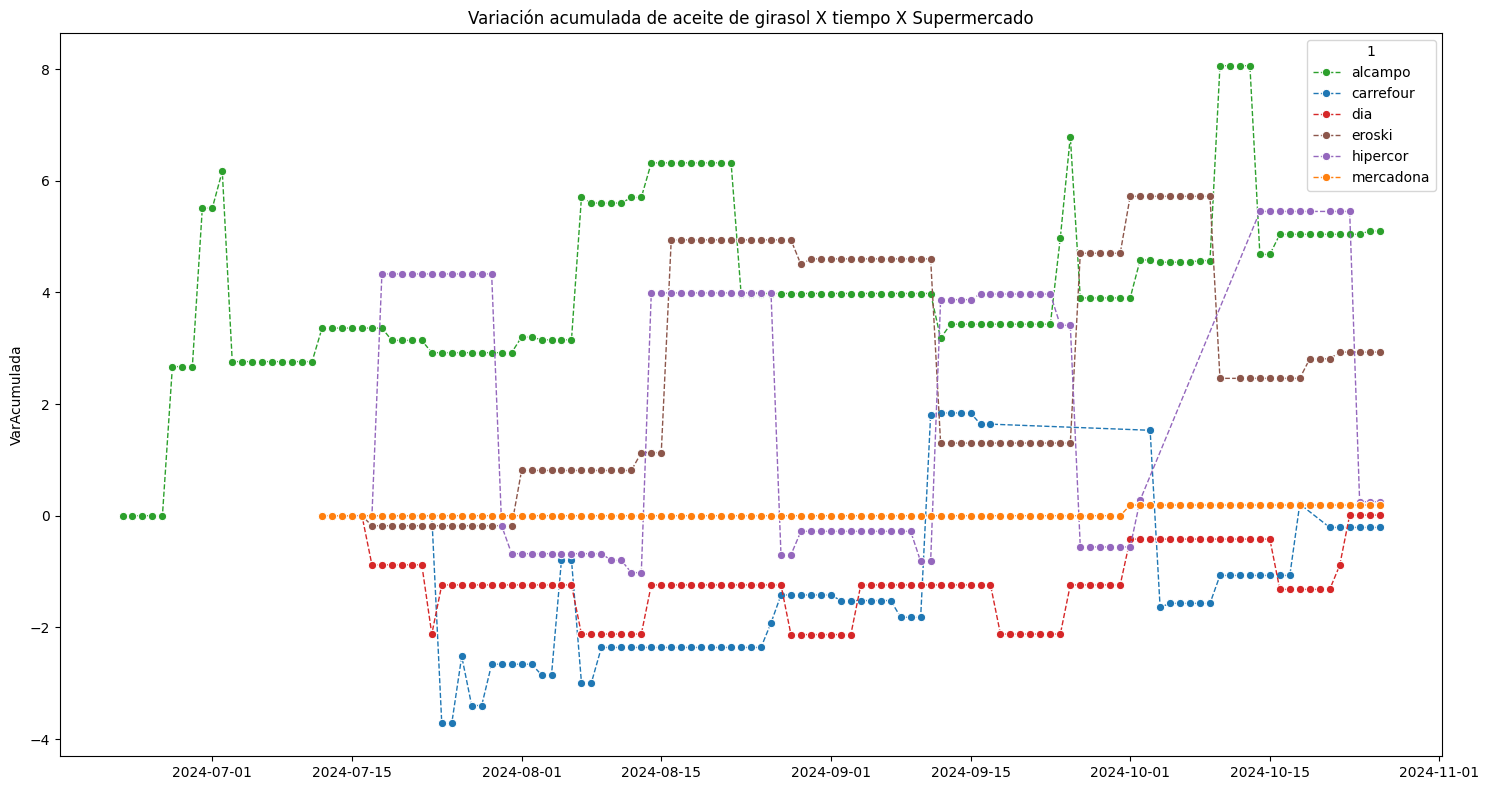

In [201]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_variacion_acumulada_precio_g[0],
              y = df_variacion_acumulada_precio_g[3], 
              hue = df_variacion_acumulada_precio_g[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Variación acumulada de aceite de girasol X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("VarAcumulada")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

En esta visualización muestra la variación de los precios de los artículos, de manera acumulada. Esto quiere decir que cada variación que existe en una categoría se irá acumulando e irá subiendo y bajando en consecuencia. Todas empiezan en 0 pero luego se observa como esta variación va en aumento o en depreciación dependiendo del alza o baja de sus precios, para entonces quedar en un nuevo escalón. De esta manera se puede ver cómo estos cambios se mantienen en el tiempo y como se perciben cuando existe tiempo de alzas y bajas continuas.

A simple vista se observa como hubo una variación para todos los supermercados entre mediados de julio--agosto en los cambios al aceite de girasol. Sin embargo, entre mediados de septiembre y octubre se aprecia un mantenimiento casi general seguido de una liera fluctuación.

El mercado que presenta menor cambio y a la vez mayor regularidad es el Mercadona. Dia se mantuvo con un comportamiento bastante irregular oscilando entre subidas y bajas de sus precios.

Evolucion de los precios a lo largo del tiempo (Aceite de oliva)

In [202]:
cursor=conexion.cursor()
query_evolucion_precios_aceite_oliva="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-oliva'
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios_aceite_oliva)
df_variacion_acumulada_precio_adeo = pd.DataFrame(cursor.fetchall())
# cursor.close()
# conexion.close()

In [203]:
df_variacion_acumulada_precio_adeo[0] = pd.to_datetime(df_variacion_acumulada_precio_adeo[0])


In [204]:
df_variacion_acumulada_precio_adeo.describe()

,0,3
count,58301,58301.000000
mean,2024-08-26 16:07:58.180477440,-78.226876
min,2024-06-22 00:00:00,-206.770000
25%,2024-07-30 00:00:00,-112.500000
50%,2024-08-25 00:00:00,-79.380000
75%,2024-09-22 00:00:00,-40.940000
max,2024-10-26 00:00:00,19.400000
std,NaN,44.339702


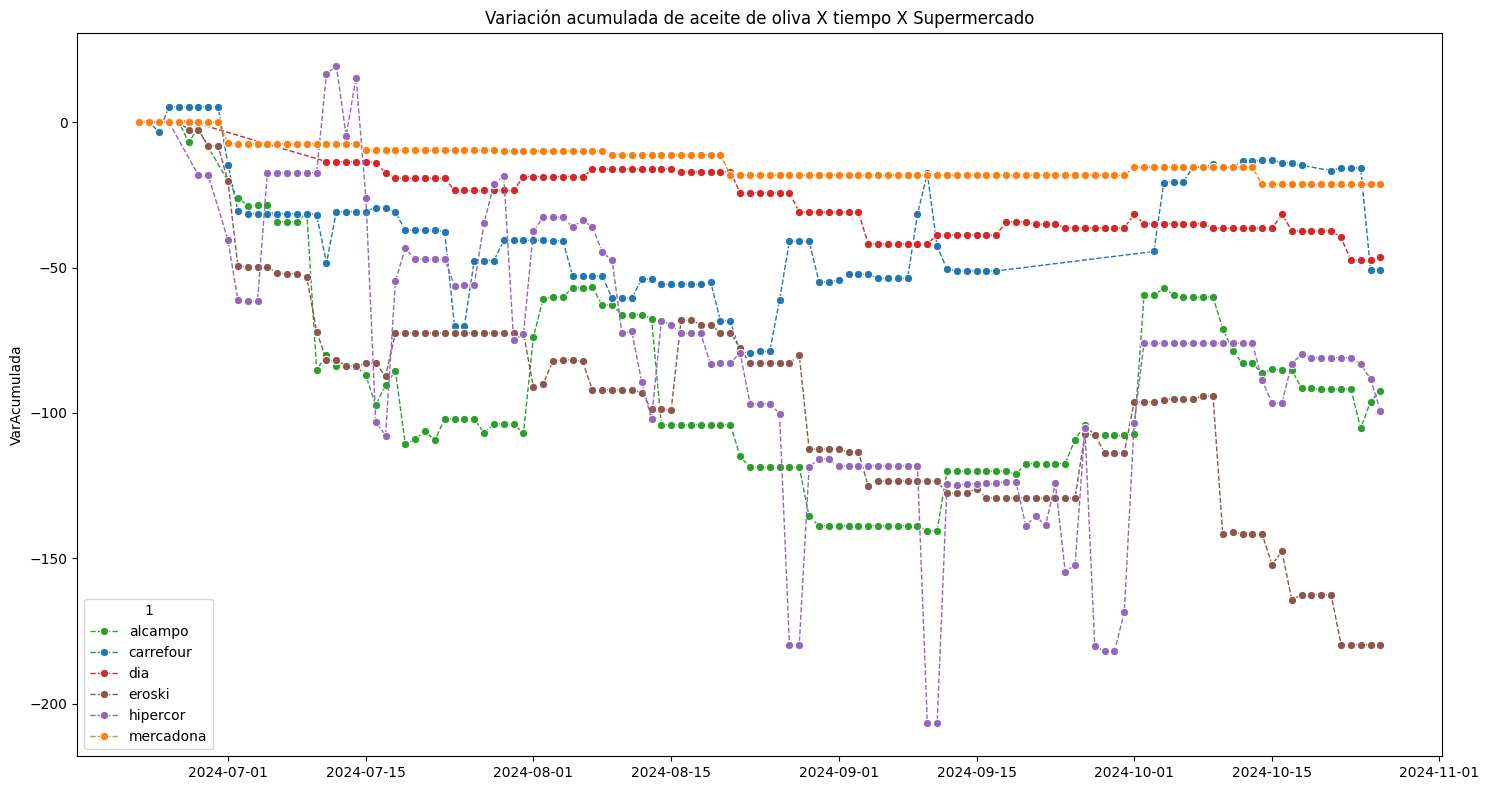

In [205]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_variacion_acumulada_precio_adeo[0],
              y = df_variacion_acumulada_precio_adeo[3], 
              hue = df_variacion_acumulada_precio_adeo[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Variación acumulada de aceite de oliva X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("VarAcumulada")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

En esta visualización se puede observar la evolución de precios a través de la variación acumulada para el aceite de oliva en el tiempo registrado. A simple vista, se ve un descenso general en los precios vía su variación. Quiero decir que contantemente este fue bajando aunque tuvo momentos en los que realizó subidas (sobre todo en el mes de agosto). Sin embargo, estas no fueron tan grandes como para regresar a su precio anterior. Lo que quiere decir que desde el registro el descenso ha sido uniforme. Señalo a Mercadona y Día como aquello con menor variación, e Hipercor con una mayor variación acumulada en su descenso. Alcampo se mantiene en un ida y vuelta en su picada.
* Se puede observar ciertas alzas generalizadas a partir del inicio del mes de octubre.

In [206]:
cursor=conexion.cursor()
query_evolucion_precios_leche="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'leche'
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios_leche)
df_variacion_acumulada_precio_leche = pd.DataFrame(cursor.fetchall())

In [207]:
df_variacion_acumulada_precio_leche[0] = pd.to_datetime(df_variacion_acumulada_precio_leche[0])

In [208]:
df_variacion_acumulada_precio_leche.head()

,0,1,2,3
0,2024-07-15,alcampo,leche,0.0
1,2024-07-15,alcampo,leche,0.0
2,2024-07-15,alcampo,leche,0.0
3,2024-07-15,alcampo,leche,0.0
4,2024-07-15,alcampo,leche,0.0


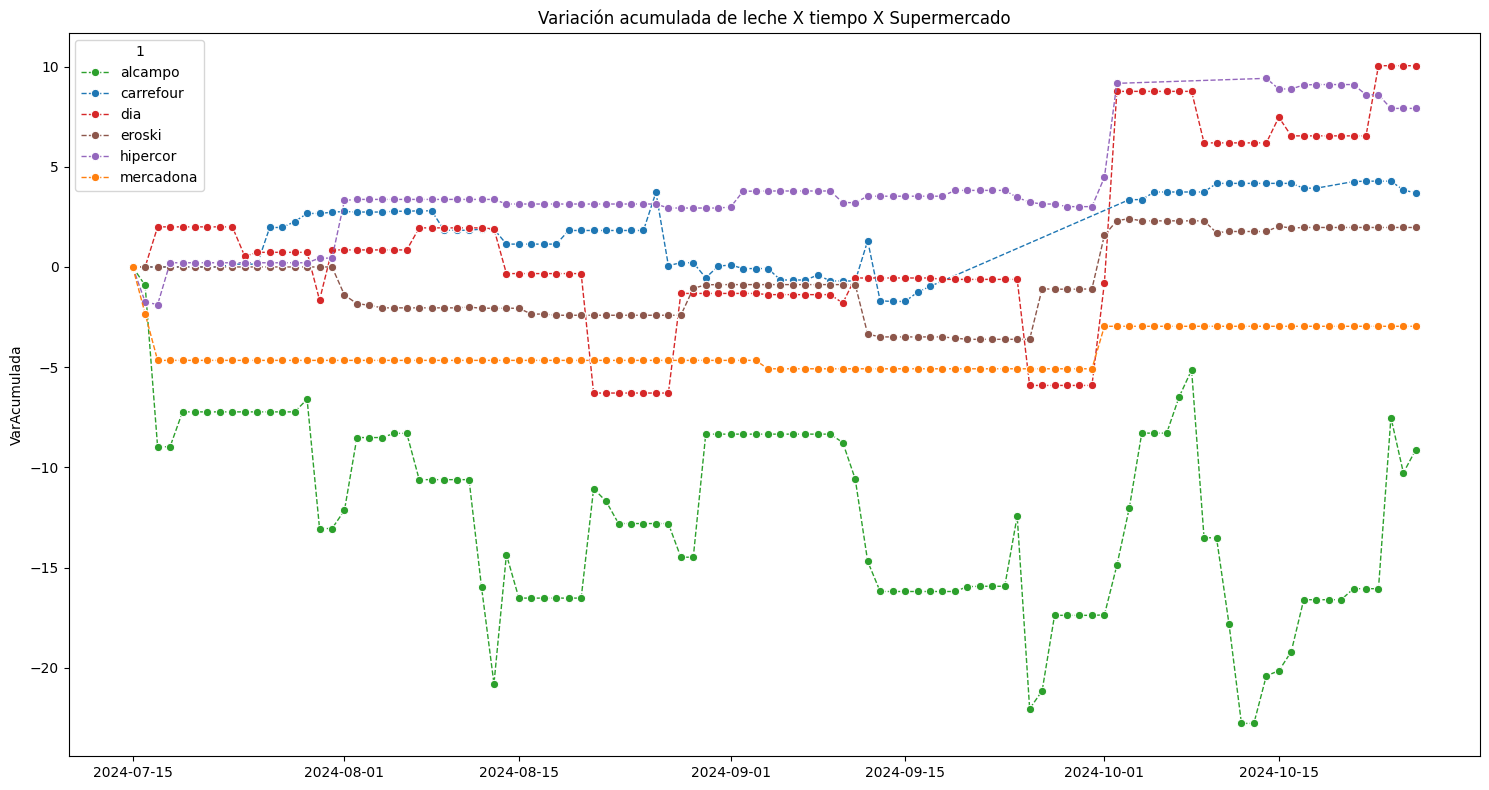

In [209]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_variacion_acumulada_precio_leche[0],
              y = df_variacion_acumulada_precio_leche[3], 
              hue = df_variacion_acumulada_precio_leche[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Variación acumulada de leche X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("VarAcumulada")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

Para ver la variación acumulada de la leche en el tiempo se puede observar que casi todos tuviero un imicio continuo del mismo precio, a diferencia de alcampo. Estos dos siguen un patrón distinto a los demás mercados ya que presentan una variación acumulada en negativo: mercadona se mantuvo muy similar al precio original mientras que alcampo tuvo muchas bajas aunque por momentos se acercó a su precio original. Los demás tuvieron un comportamiento más regular. Estuvieron oscilando cerca del precio original, aunque luego presentaron una ligera variación donde se mantuvieron.

Anomalías de precios por tiempo (aceite de girasol)

In [210]:
#variacion buena por picadas

cursor=conexion.cursor()
query_anomalias_girasol="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-girasol'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_anomalias_girasol)
df_anomalias_girasol= pd.DataFrame(cursor.fetchall())

In [211]:
df_anomalias_girasol[0] = pd.to_datetime(df_anomalias_girasol[0])

In [212]:
df_anomalias_girasol.head()

,0,1,2,3
0,2024-09-07,mercadona,aceite-de-girasol,0.0
1,2024-07-19,dia,aceite-de-girasol,0.0
2,2024-07-30,alcampo,aceite-de-girasol,0.0
3,2024-07-13,eroski,aceite-de-girasol,0.0
4,2024-10-14,mercadona,aceite-de-girasol,0.0


In [213]:
df_anomalias_girasol.describe()

,0,3
count,631,631.000000
mean,2024-08-30 15:44:47.163233024,0.013106
min,2024-06-22 00:00:00,-5.200000
25%,2024-08-04 00:00:00,0.000000
50%,2024-08-30 00:00:00,0.000000
75%,2024-09-27 00:00:00,0.000000
max,2024-10-26 00:00:00,5.170000
std,NaN,0.767295


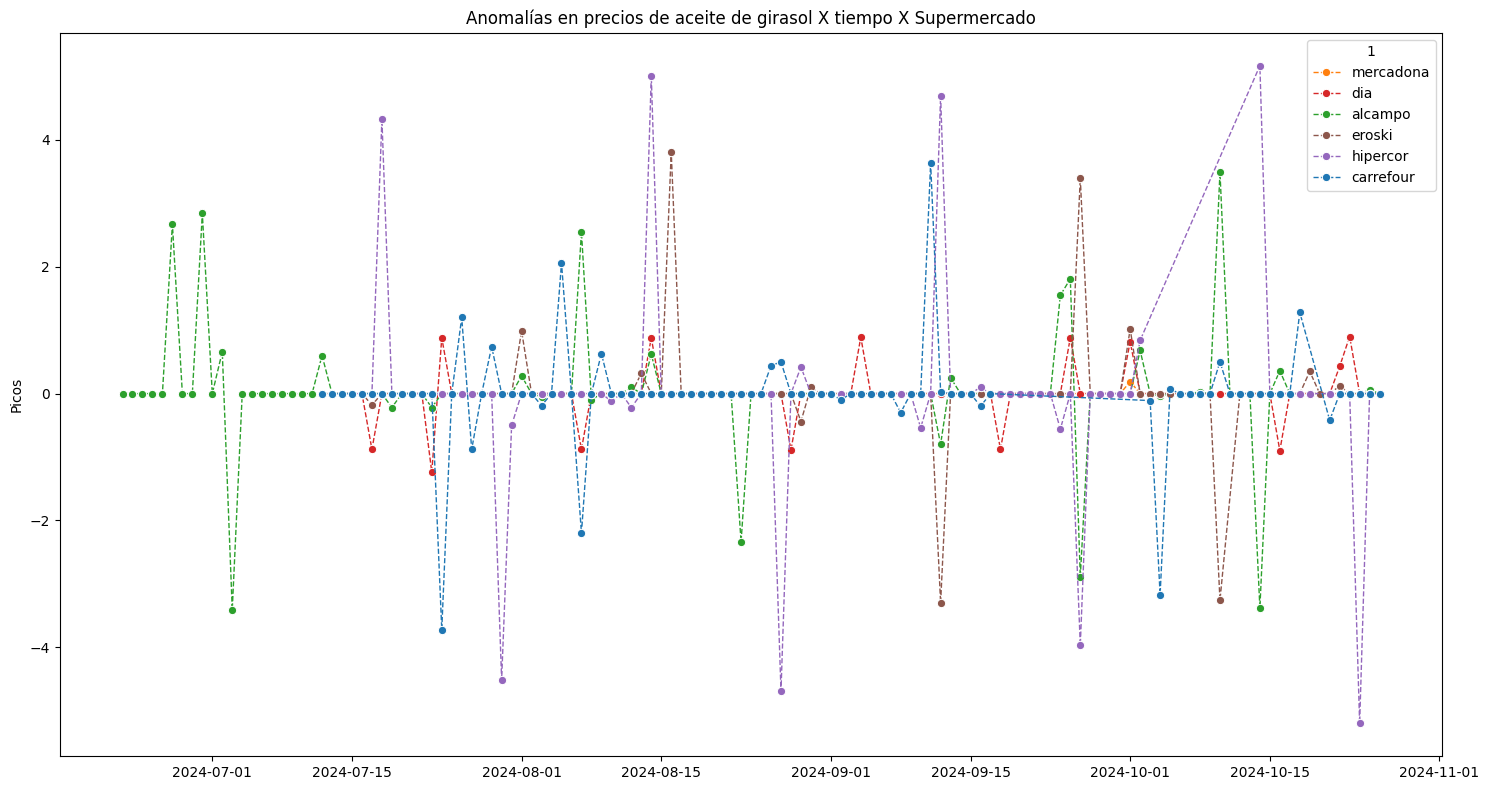

In [214]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_anomalias_girasol[0],
              y = df_anomalias_girasol[3], 
              hue = df_anomalias_girasol[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Anomalías en precios de aceite de girasol X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Picos")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

En el gráfico se pueden observar anomalías de precios para el aceite de girasol (aumentos y bajadas en los distintos supermercados) desde el inicio del registro histórico. No se observa ninguna gran variación de anomalías en mercadona, mientras que el Día mantiene un funcionamiento regular entre subidas y bajadas ligeras. 
En el caso de Carrefour e Hipercor, se ven variaciones mas notables tanto en aumento como descenso destacando movimientos entre mediados de julio a mediados de agosto. Eroski también mantiene un comportamiento regular con algunas ligeras subidas, mientras que Alcampo presenta un inicio con picadas y un periodo mas reciente con ambos movimientos. En el mes presente, se observan subidas y bajas intermitentes.

Anomalías por aceite de oliva

In [215]:
#variacion buena por picadas

cursor=conexion.cursor()
query_anomalias_aceiteoliva="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-oliva'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_anomalias_aceiteoliva)
df_anomalias_oliva= pd.DataFrame(cursor.fetchall())

In [216]:
df_anomalias_oliva[0] = pd.to_datetime(df_anomalias_oliva[0])

In [217]:
df_anomalias_oliva.head()

,0,1,2,3
0,2024-09-07,mercadona,aceite-de-oliva,0.00
1,2024-07-19,dia,aceite-de-oliva,0.00
2,2024-07-30,alcampo,aceite-de-oliva,-0.01
3,2024-07-13,eroski,aceite-de-oliva,-2.11
4,2024-10-14,mercadona,aceite-de-oliva,-5.88


In [218]:
df_anomalias_oliva.describe()

,0,3
count,720,720.000000
mean,2024-08-25 02:03:59.999999744,-0.680792
min,2024-06-22 00:00:00,-88.580000
25%,2024-07-26 00:00:00,0.000000
50%,2024-08-25 00:00:00,0.000000
75%,2024-09-25 00:00:00,0.000000
max,2024-10-26 00:00:00,82.350000
std,NaN,11.247102


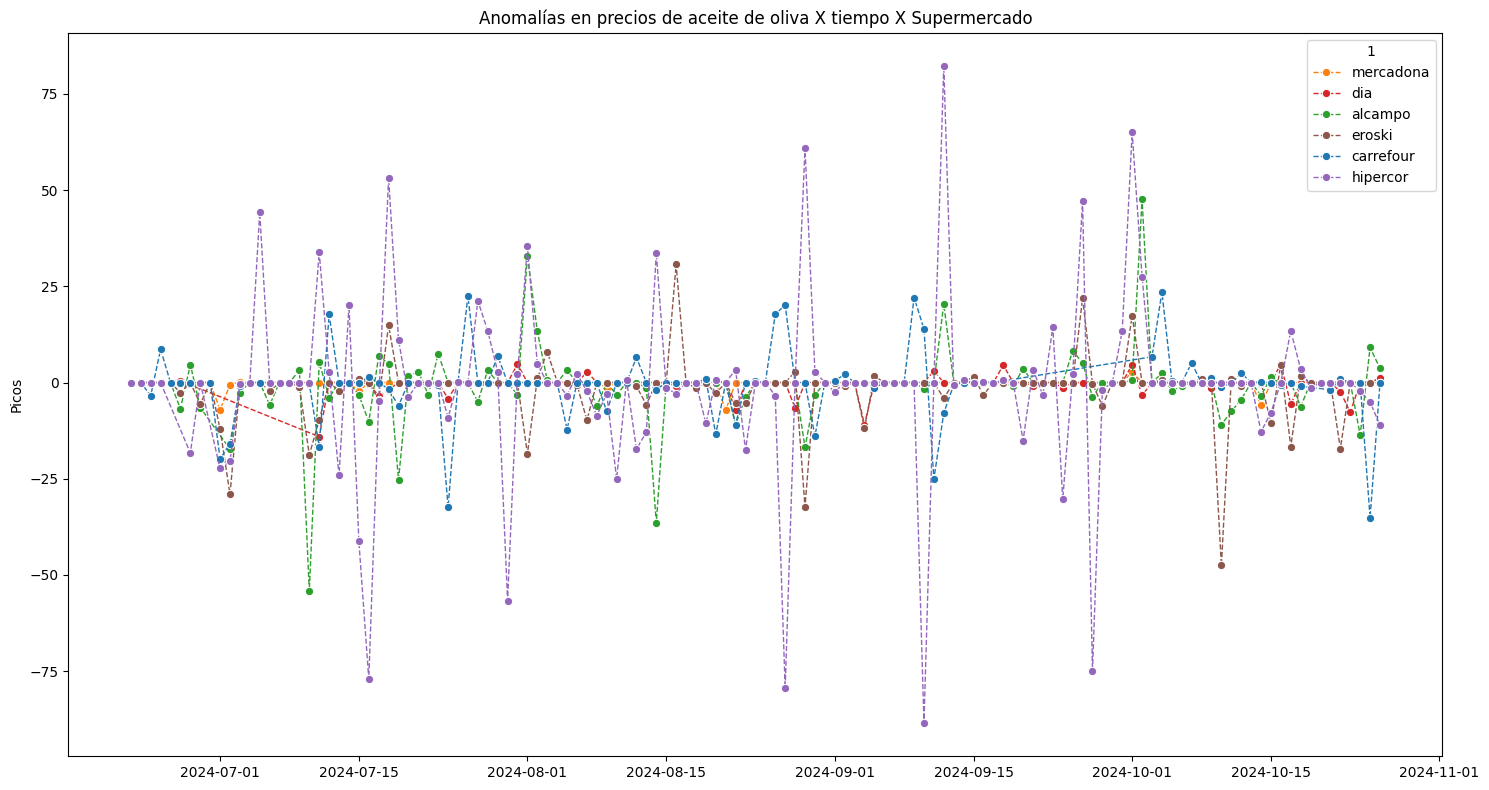

In [286]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_anomalias_oliva[0],
              y = df_anomalias_oliva[3], 
              hue = df_anomalias_oliva[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Anomalías en precios de aceite de oliva X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Picos")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

En referencia al aceite de oliva, se puede ver una gráfica con mucho movimiento. A principio hubo un descenso en variación general, seguido con un periodo estable para luego dar entrada a una serie de movimientos en alza y baja hasta mediados de agosto. Desde mediados de agosto se produjo picos en descenso general para luego volver a un momento prácticamente general de estabilidad. Luego a principios d octubre hubo varios picos en la variación casi en todos los mercados pero esto sería contrarrestado por los picos en descenso que le seguirían para casi todos.
* Es preciso señalar el caso de hipercor como aquel que sufrió los picos más altos y más bajos en todo el tiempo medido.

Anomalías por leche

In [220]:
#variacion buena por picadas

cursor=conexion.cursor()
query_anomalias_leche="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'leche'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_anomalias_leche)
df_anomalias_leche= pd.DataFrame(cursor.fetchall())

In [221]:
df_anomalias_leche[0] = pd.to_datetime(df_anomalias_leche[0])

In [222]:
df_anomalias_leche.head()

,0,1,2,3
0,2024-09-07,mercadona,leche,0.00
1,2024-07-19,dia,leche,0.00
2,2024-07-30,alcampo,leche,-6.45
3,2024-10-14,mercadona,leche,0.00
4,2024-08-31,eroski,leche,0.01


In [223]:
df_anomalias_leche.describe()

,0,3
count,596,596.000000
mean,2024-09-03 05:09:15.704698112,0.019362
min,2024-07-15 00:00:00,-9.610000
25%,2024-08-08 00:00:00,0.000000
50%,2024-09-02 00:00:00,0.000000
75%,2024-09-29 00:00:00,0.000000
max,2024-10-26 00:00:00,9.560000
std,NaN,1.345268


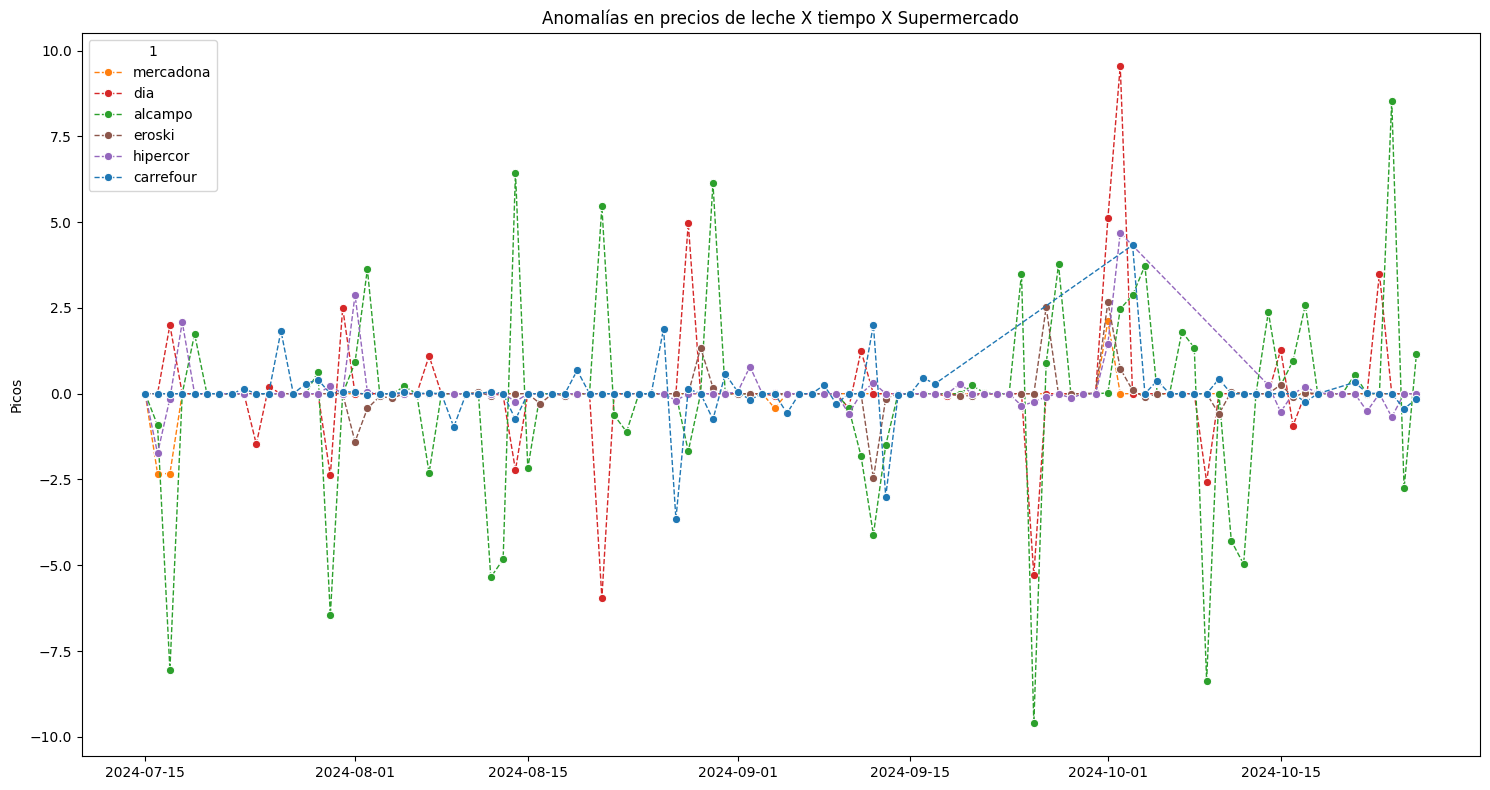

In [287]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_anomalias_leche[0],
              y = df_anomalias_leche[3], 
              hue = df_anomalias_leche[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Anomalías en precios de leche X tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Picos")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

Con respecto a la leche, hubo pequeños aumentos en su variación hacia principios de agosto en cadenas como dia, alcampo e hipercor, mientras que las demás mantenían su precio o incluso tenían ligeros descensos. Para principios de septiembre se puede observar un aumento en algunos seguido de un descenso general para mediados del mismo mes en general. Para octubre, se inicia con picos de variación seguido de días sin movimiento para volver a presentarse picos. 
* Carrefour se mantiene muy constante en cuanto a su variación, a diferencia de mercados como Día y Alcampo.
* Los demás, mantienen un movimiento casi nulo.

Cambios de precio Aceite de girasol

In [292]:
#variacion buena por picadas

cursor=conexion.cursor()
query_cambios_precio_girasol="""
SELECT fecha, s.supermercado , c.categoria , avg(dh.precio) AS cambio_promedio_ag
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-girasol'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_cambios_precio_girasol)
df_cambios_girasol= pd.DataFrame(cursor.fetchall())

In [293]:
df_cambios_girasol[0] = pd.to_datetime(df_cambios_girasol[0])

In [294]:
df_cambios_girasol.describe()

,0,3
count,631,631.000000
mean,2024-08-30 15:44:47.163233024,4.666215
min,2024-06-22 00:00:00,1.270000
25%,2024-08-04 00:00:00,3.718333
50%,2024-08-30 00:00:00,4.100000
75%,2024-09-27 00:00:00,4.986667
max,2024-10-26 00:00:00,10.271667
std,NaN,1.575741


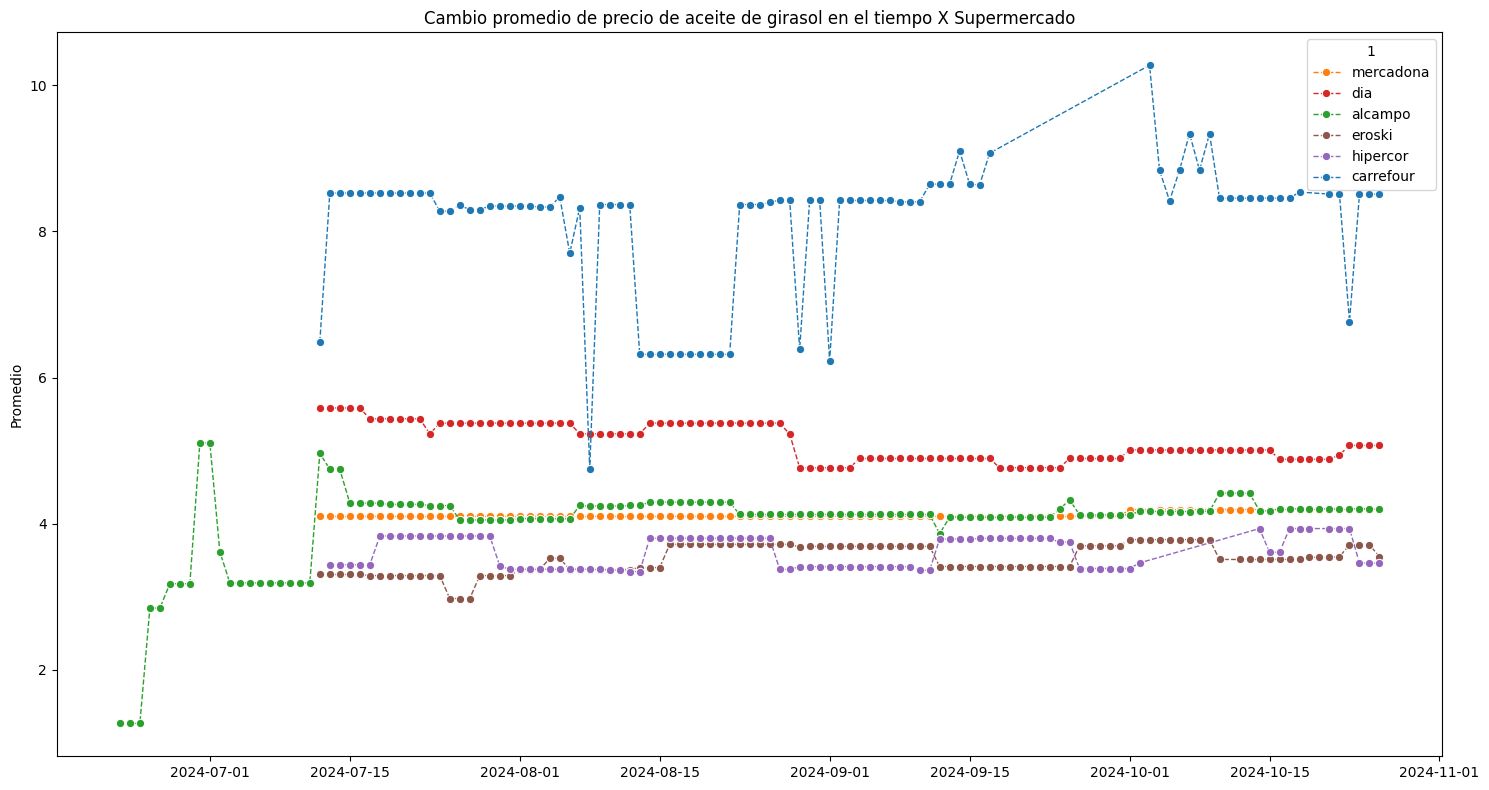

In [295]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_cambios_girasol[0],
              y = df_cambios_girasol[3], 
              hue = df_cambios_girasol[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Cambio promedio de precio de aceite de girasol en el tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Promedio")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

De esta forma se puede comprobar el aumento, o baja, promedio que se hace por categoría. 
* En casi todos los supermercados, entre mediados de julio se produjeron ligeros 

In [246]:
cursor=conexion.cursor()
query_cambios_precio_oliva="""
SELECT fecha, s.supermercado , c.categoria , avg(dh.precio) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-oliva'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_cambios_precio_oliva)
df_cambios_oliva= pd.DataFrame(cursor.fetchall())

In [247]:
df_cambios_oliva[0] = pd.to_datetime(df_cambios_oliva[0])

In [248]:
df_cambios_oliva.describe()

,0,3
count,720,720.000000
mean,2024-08-25 02:03:59.999999744,16.425977
min,2024-06-22 00:00:00,7.450000
25%,2024-07-26 00:00:00,12.596174
50%,2024-08-25 00:00:00,14.190428
75%,2024-09-25 00:00:00,20.073852
max,2024-10-26 00:00:00,29.042857
std,NaN,4.337599


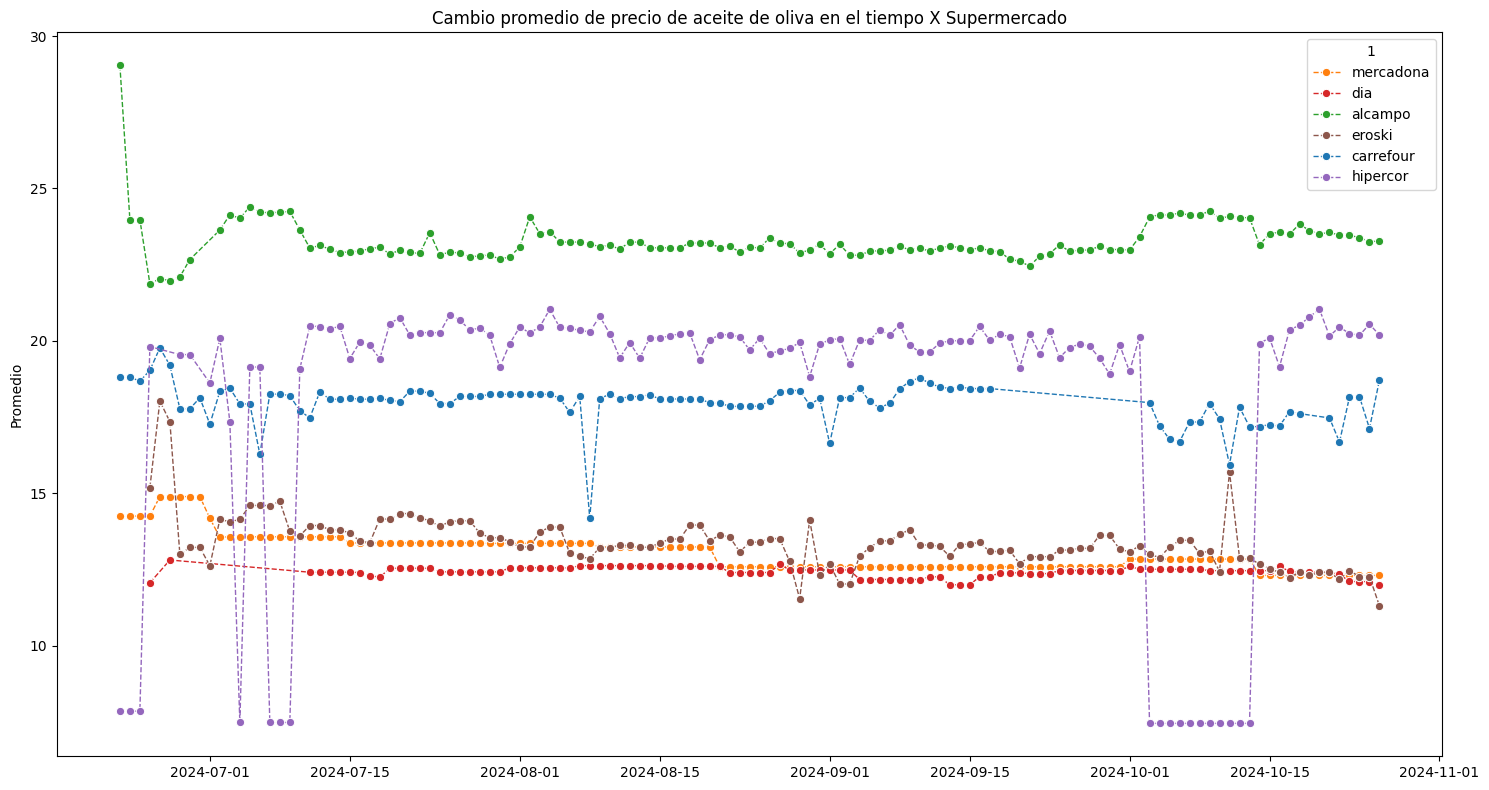

In [251]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_cambios_oliva[0],
              y = df_cambios_oliva[3], 
              hue = df_cambios_oliva[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Cambio promedio de precio de aceite de oliva en el tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Promedio")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

In [233]:
cursor=conexion.cursor()
query_cambios_precio_leche="""
SELECT fecha, s.supermercado , c.categoria , avg(dh.precio) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'leche'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_cambios_precio_leche)
df_cambios_leche= pd.DataFrame(cursor.fetchall())

In [234]:
df_cambios_leche[0] = pd.to_datetime(df_cambios_leche[0])

In [235]:
df_cambios_leche.describe()

,0,3
count,596,596.000000
mean,2024-09-03 05:09:15.704698112,2.821844
min,2024-07-15 00:00:00,1.434906
25%,2024-08-08 00:00:00,1.572158
50%,2024-09-02 00:00:00,3.621481
75%,2024-09-29 00:00:00,4.032564
max,2024-10-26 00:00:00,5.248553
std,NaN,1.191561


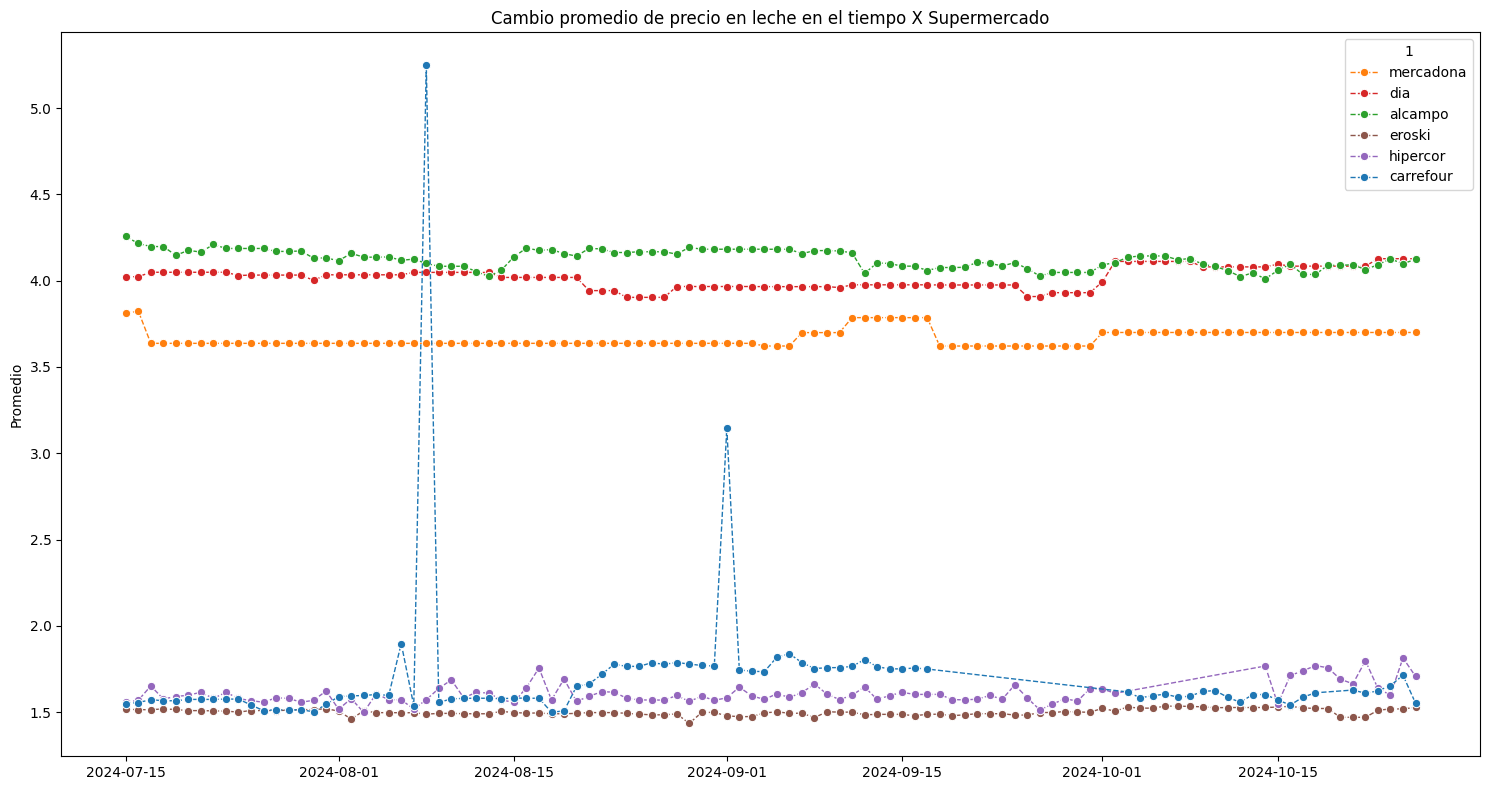

In [252]:
plt.figure(figsize=(15,8))
sns.lineplot(x = df_cambios_leche[0],
              y = df_cambios_leche[3], 
              hue = df_cambios_leche[1], 
               marker = "o", 
                linewidth = 1, 
                palette=paleta_supermercados, 
                linestyle = "dashed", 
                errorbar = None)
plt.title("Cambio promedio de precio en leche en el tiempo X Supermercado")
plt.xlabel("")
plt.ylabel("Promedio")
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

Análisis de la Dispersión de Precios: Evaluar la variabilidad de los precios de un mismo producto en diferentes supermercados.

In [237]:
cursor=conexion.cursor()
query_dispersion_precios= """
SELECT c.categoria , s.supermercado, 
avg(dh.precio) AS precio_promedio,
min(dh.precio) AS precio_minimo,
max(dh.precio) AS precio_maximo
FROM datos_historicos dh 
inner JOIN supermercado s 
ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c 
ON dh.id_categoria = c.id_categoria 
GROUP BY c.categoria, s.supermercado 
ORDER BY c.categoria;
"""
cursor.execute(query_dispersion_precios)
df_dispersion_precios= pd.DataFrame(cursor.fetchall())

In [238]:
df_dispersion_precios.head()

,0,1,2,3,4
0,aceite-de-girasol,alcampo,4.131640,1.00,15.88
1,aceite-de-girasol,carrefour,8.183978,1.45,40.67
2,aceite-de-girasol,dia,5.100328,1.49,10.99
3,aceite-de-girasol,eroski,3.522112,1.39,11.99
4,aceite-de-girasol,hipercor,3.613664,1.40,12.79


Comparación de Precios Promedio: Calcular y comparar los precios promedio de cada producto en diferentes supermercados.

In [296]:
cursor=conexion.cursor()
query_comparar_precios = """
SELECT round(CAST (avg(precio) AS NUMERIC), 2) AS precio_pomedio, s.supermercado , c.categoria 
FROM datos_historicos dh 
inner JOIN supermercado s 
ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c 
ON dh.id_categoria = c.id_categoria 
WHERE dh.fecha = '26-10-2024'
GROUP BY s.supermercado , c.categoria 
ORDER BY c.categoria;
"""
cursor.execute(query_comparar_precios)
df_comparacion_precios = pd.DataFrame(cursor.fetchall())

In [297]:
df_comparacion_precios.head()

,0,1,2
0,4.21,alcampo,aceite-de-girasol
1,8.51,carrefour,aceite-de-girasol
2,5.07,dia,aceite-de-girasol
3,3.55,eroski,aceite-de-girasol
4,3.46,hipercor,aceite-de-girasol


Promedio

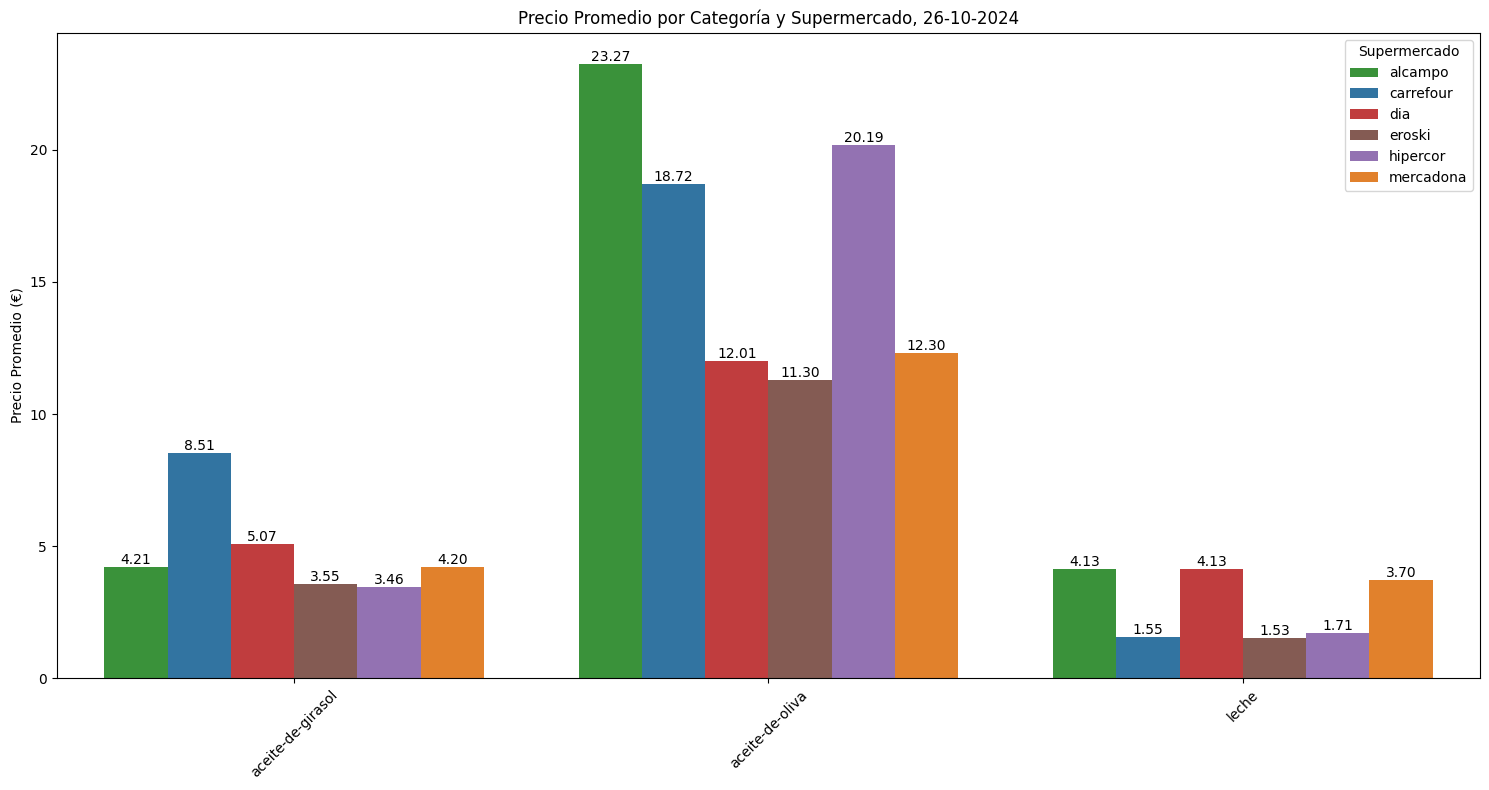

In [303]:
plt.figure(figsize=(15, 8))
sns.barplot(
    data=df_comparacion_precios, 
    x=2, 
    y=0, 
    hue=1, 
    palette=paleta_supermercados
)

plt.title("Precio Promedio por Categoría y Supermercado, 26-10-2024")
plt.xlabel("")
plt.ylabel("Precio Promedio (€)")
plt.xticks(rotation=45)
plt.legend(title="Supermercado")
plt.tight_layout()

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt="%.2f", label_type="edge")

plt.show()
